### Submission Instructions

Just fill in the markdown and code cells below with your arguments and functions, and run the Python lines given. Make sure the notebook works fine by executing `Kernel/Restart & Run All`.
  
Once the notebook is ready,
1. Create a folder named `ftdl_last_name1_last_name2` with the team's last names.

2. Put in that folder:

* a file `mp_ftdl_last_name1_last_name2.ipynb` with the cells below completed. Make sure it works by executing Kernel/Restart & Run All.
* a file `mp_ftdl_last_name1_last_name2.html` with an html rendering of the previous .ipynb file (just apply File / Download as HTML after a correct run of Kernel/Restart & Run All).
* a file `mp_ftdl_last_name1_last_name2.pdf` with a pdf print of the html file **without any code**.

3. Compress the folder to a `ftdl_last_name1_last_name2.7z` 7z (or zip) file.

**Very important!!!**

Make sure you follow the file naming conventions above; the miniproject won't be graded until that is so.

## Recommendations in notebook writing

Notebooks are a great tool for data and model exploration. But in that process a lot of Python garbage can get into them as a consequence of the trial and error process.

But once these tasks are done and one arrives to final ideas and insights on the problem under study, the notebook should be **thoroughly cleaned** and the notebook should **concentrate on the insights and conclussions** without, of course, throwing away the good work done.

Below there are a few guidelines about this.

* Put the useful bits of your code as functions on a **Python module** (plus script, if needed) that is imported at the notebook's beginning. 
* Of course that module should be **properly documented** and **formatted** (try to learn about PEP 8 if you are going to write a lot of Python).
* Leave in the notebook **as little code as possible**, ideally one- or two-line cells calling a function, plotting results or so on.
* **Avoid boilerplate code**. If needed, put it in a module.
* Put on the notebook some way to **hide/display the code** (as shown below).
* The displayed information **should be just that, informative**. So forget about large tables, long output cells, dataframe or array displays and so on.
* Emphasize **insights and conclusions**, using as much markdown as needed to clarifiy and explain them.
* Make sure that **number cells consecutively starting at 1.**
* And, of course, make sure that **there are no errors left**. To avoid these last pitfalls, run `Kernel\Restart Kernel and Run All Cells`.

And notice that whoever reads your notebook is likely to toggle off your code and consider just the markdown cells. Because of this, once you feel that your notebook is finished,
* let it rest for one day, 
* then open it up, toggle off the code 
* and read it to check **whether it makes sense to you**.

If this is not the case, **the notebook is NOT finished!!!**

Following these rules you are much more likely to get good grades at school (and possibly also larger bonuses at work).

**IMPORTANT AND JUST IN CASE: before turning in your work, please REMOVE FROM IT THE PREVIOUS TWO CELLS**

In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Wind Energy Prediction
We want to predict the wind energy production on a farm using wind speed and direction information.

The aim of this wind power forecasting problem is to predict the wind power generation 24 h ahead for a wind farm in Australia.

Attribute Information:
The features include forecasts of the projections of the wind vector on the west-east (U) and south-north (V) axes,at two heights, 10 and 100 m above ground level, plus the corresponding absolute wind speeds.

Data for a 10 month period are given in a csv file with headers

`TIMESTAMP,TARGETVAR,U10,V10,U100,V100,v10,v100`

where

* TIMESTAMP contains day/hour information.
* TARGETVAR is the wind energy production normalized to a [0, 100] range.
* U10,V10,U100,V100 are the U and V wind components in m/s at heights 10 and 100.
* v10,v100 are the absolute wind speeds in m/s at heights 10 and 100.

The dataset we will use is an adaptation of those available in the Kaggle page https://www.kaggle.com/c/GEF2012-wind-forecasting. 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import time
import pickle
import gzip

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, KFold, GridSearchCV

from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error

import joblib

## Data Loading

The dataset is preloaded in the sciki-learn library.

In [3]:
df_0 = pd.read_csv('.\w_e.csv', index_col=0, parse_dates=True)
l_vars = df_0.columns[1 : ]
print(l_vars)
df = df_0[l_vars]
df['target'] = df_0['TARGETVAR']

print ("nFilas: %d\tnColumnas: %d\n" % (df.shape[0], df.shape[1]) )
print ("Columnas:\t", np.array(df.columns))

Index(['U10', 'V10', 'U100', 'V100', 'v10', 'v100'], dtype='object')
nFilas: 6576	nColumnas: 7

Columnas:	 ['U10' 'V10' 'U100' 'V100' 'v10' 'v100' 'target']


# Data Exploration, Visualization and Correlations

* Compute descriptive statistics.
* Draw boxplots, pairplots and histograms.
* Compute and present correlations. 

Give your comments and conclusions after each step.

## Descriptive analysis

In [4]:
df.head()

,U10,V10,U100,V100,v10,v100,target
TIMESTAMP,,,,,,,
2012-01-01 01:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000
2012-01-01 02:00:00,2.521695,-1.796960,3.344859,-2.464761,3.096451,4.154892,5.487912
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400
2012-01-01 04:00:00,2.457504,-0.143642,3.215233,-0.355546,2.461699,3.234831,16.511606
2012-01-01 05:00:00,2.245898,0.389576,2.957678,0.332701,2.279435,2.976332,15.694013


In [6]:
df.describe().round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
U10,6576.0,0.93,2.55,-7.49,-1.09,0.78,2.48,11.12
V10,6576.0,-0.25,2.99,-9.99,-2.38,0.01,1.96,9.07
U100,6576.0,1.59,4.25,-10.91,-1.77,1.41,4.64,16.99
V100,6576.0,-0.48,5.13,-15.29,-4.80,0.30,3.61,14.31
v10,6576.0,3.63,1.78,0.12,2.20,3.33,4.79,11.74
v100,6576.0,6.33,2.65,0.08,4.43,6.18,8.00,18.49
target,6576.0,30.99,29.57,0.00,5.83,21.36,50.16,99.95


As we can see, there are no missing values and value ranges appear to be reasonable

## Boxplots

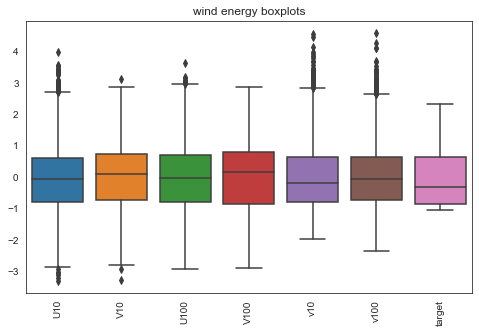

In [5]:
#normalizamos para tener rangos uniformes en histogramas
df_normalized = (df - df.mean()) / df.std() 

plt.figure( figsize=(8, 5))
sns.set_style("white")
#bx_plot = sns.boxplot(data=df_housing)
bx_plot = sns.boxplot(data=df_normalized)
#bx_plot = sns.boxplot(data=df_housing)
plt.title("wind energy boxplots")
plt.xticks(rotation=90)
plt.show()

## Histograms and scatterplots

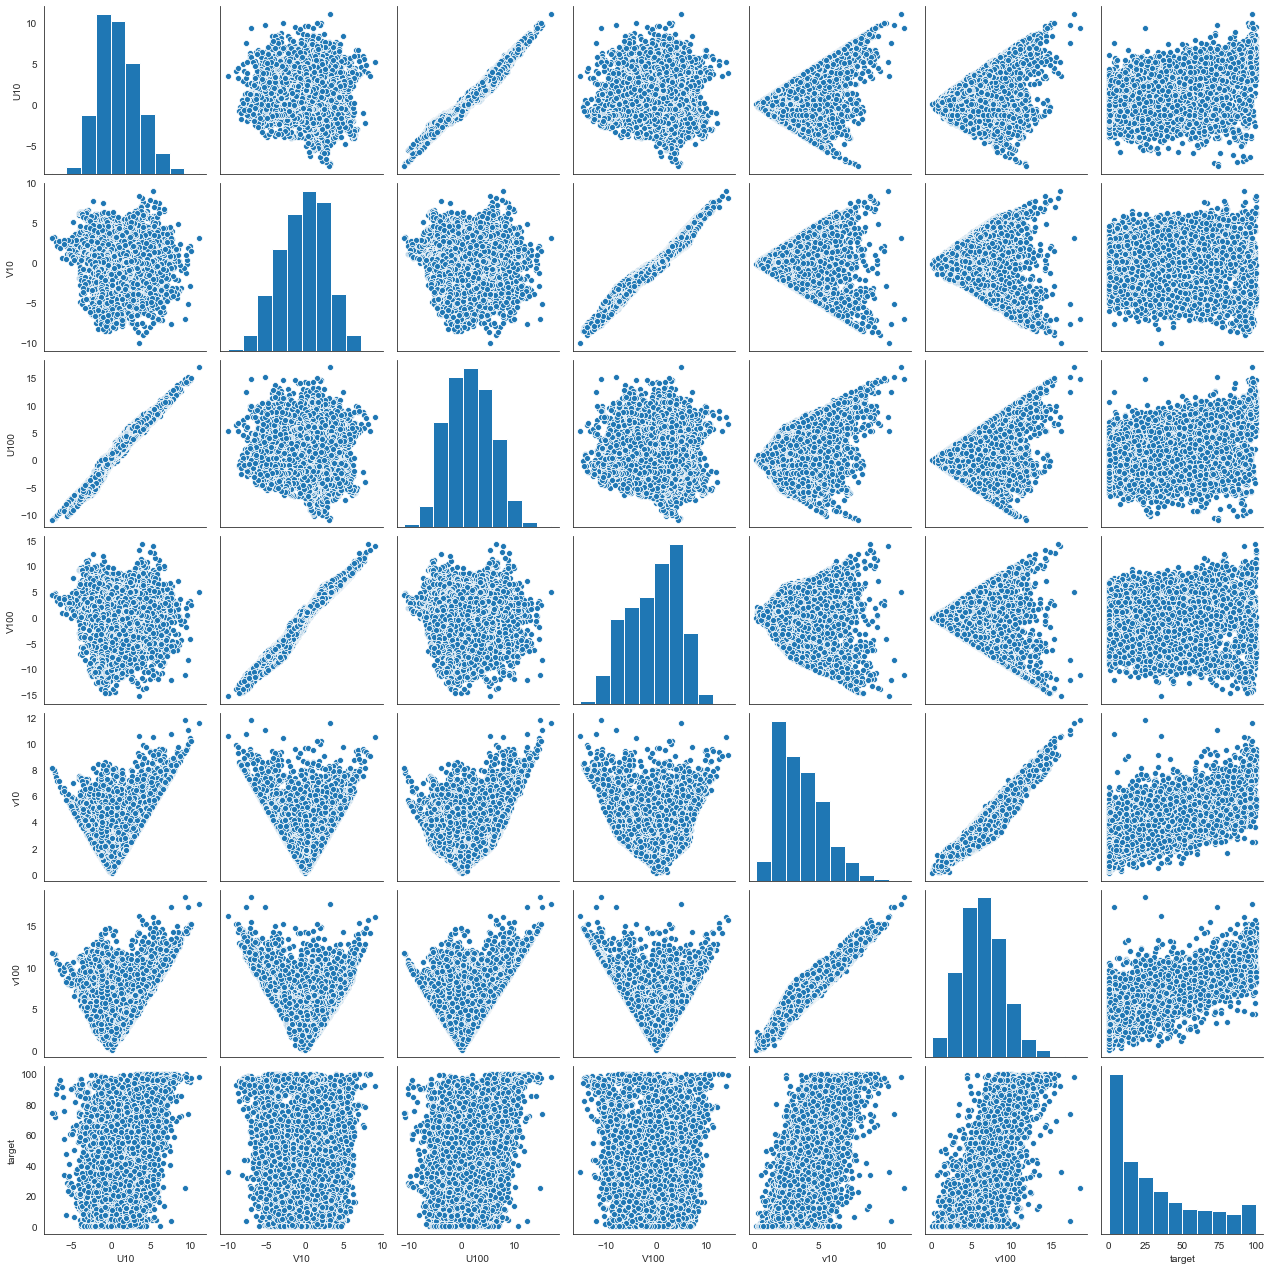

In [6]:
num_vars_to_show = 6 
pair_plot = sns.pairplot(df[list(l_vars)[:num_vars_to_show] + ['target']])
plt.show()

It seems that there are no variables which have a linear relationship with the target. However, there is a clearly linear relationship bethween some of the variables. For intance, bethween v10 and v100

## Correlations

In [7]:
df.corr().round(decimals=3)

,U10,V10,U100,V100,v10,v100,target
U10,1.000,-0.098,0.981,-0.058,0.441,0.392,0.377
V10,-0.098,1.000,-0.133,0.981,-0.162,-0.257,-0.166
U100,0.981,-0.133,1.000,-0.095,0.394,0.364,0.365
V100,-0.058,0.981,-0.095,1.000,-0.172,-0.279,-0.177
v10,0.441,-0.162,0.394,-0.172,1.000,0.915,0.706
v100,0.392,-0.257,0.364,-0.279,0.915,1.000,0.745
target,0.377,-0.166,0.365,-0.177,0.706,0.745,1.000


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

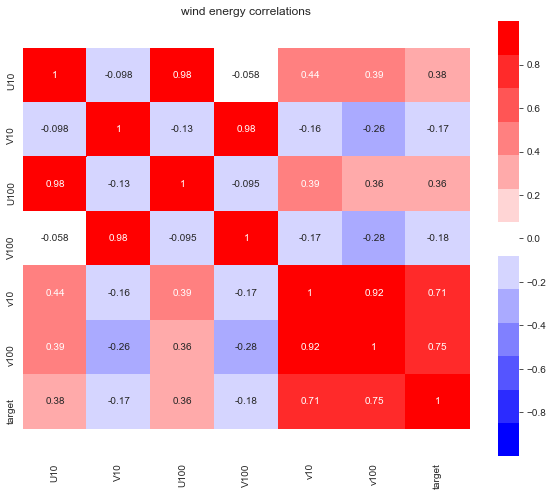

In [11]:
# definir el color map
n_colors = 13
cMap = plt.cm.get_cmap("bwr",lut=n_colors ) 

# definir el heatmap
fig = plt.figure( figsize=(10, 8))
plt.title('wind energy correlations')
#plt.colorbar(cMap, ticks=[-1, 0, 1])
h_map = sns.heatmap(df.corr().values, 
                    vmin=-1., vmax=1., 
                    cmap=cMap,
                    annot=True,
                    xticklabels=list(df.columns),
                    yticklabels=list(df.columns))
plt.xticks(rotation=90) 

# poner ticks en la barra de color
cbar = h_map.collections[0].colorbar
l_ticks = [k/10. for k in range(-8, 9, 2)]
cbar.set_ticks(l_ticks)

# arreglar cosillas
bottom, top = h_map.get_ylim()
h_map.set_ylim(bottom + 0.5, top - 0.5)

# generar el dibujo
plt.show()

## Overall conclusions

In [ ]:
# TODO

# MLPRegressor

Perform a CV MLPR estimation of a pipelined MLPR over three folds over the entire sample.

In [13]:
from sklearn.model_selection import TimeSeriesSplit

In [22]:
sc = StandardScaler()

x = sc.fit_transform(df[l_vars])
y = df[['target']]

In [23]:
#USAMOS KFOLD CV
n_folds = 3
kf = KFold(n_folds, shuffle=False)
hidden_layer_sizes = (30, 30)

mlpr_kf =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                     activation='relu', 
                     solver='lbfgs', 
                     early_stopping=True,
                     tol=1.e-3, 
                     max_iter=10000)

regr_kf = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('mlp', mlpr_kf)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr_kf,
                                             transformer=y_transformer)

l_alpha = [10.**k for k in range(-6, 7)]
param_grid = {'regressor__mlp__alpha': l_alpha}  
#'regressor__mlp__hidden_layer_sizes': [(20,), (20, 20), (20, 20, 20)]}


cv_estimator_kf = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error',
                            return_train_score=True,
                            refit=True,
                            n_jobs=-1, 
                            verbose=1)

t_0 = time.time()
cv_estimator_kf.fit(x, y)
t_1 = time.time() 
print("\nmlp_grid_search_time: %.2f" % ((t_1 - t_0)/60.))
        
# saving alpha_search in a pickle    
f_name = 'mlp_alpha_search_results_kf.joblib'
joblib.dump(cv_estimator_kf, f_name, compress=3)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 28.8min finished



mlp_grid_search_time: 28.85


['mlp_alpha_search_results_kf.joblib']

In [18]:
#USAMOS TIMESERIESSPLIT

tscv = TimeSeriesSplit(n_splits=3)
hidden_layer_sizes = (30, 30)

mlpr =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                     activation='relu', 
                     solver='lbfgs', 
                     early_stopping=True,
                     tol=1.e-3, 
                     max_iter=10000)

regr = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('mlp', mlpr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

l_alpha = [10.**k for k in range(-6, 7)]
param_grid = {'regressor__mlp__alpha': l_alpha}  
#'regressor__mlp__hidden_layer_sizes': [(20,), (20, 20), (20, 20, 20)]}


cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=tscv, 
                            scoring='neg_mean_absolute_error',
                            return_train_score=True,
                            refit=True,
                            n_jobs=-1, 
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x, y)
t_1 = time.time() 
print("\nmlp_grid_search_time: %.2f" % ((t_1 - t_0)/60.))
        
# saving alpha_search in a pickle    
f_name = 'mlp_alpha_search_results.joblib'
joblib.dump(cv_estimator, f_name, compress=3)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 13.0min finished



mlp_grid_search_time: 13.11


['mlp_alpha_search_results.joblib']

## Analyzing GridSearchCV results

Check the adequacy of the best hyperparameters.

alpha_range: 0.00 - 1000000.00
best_alpha = 10.00
best_cv_mae = 13.454


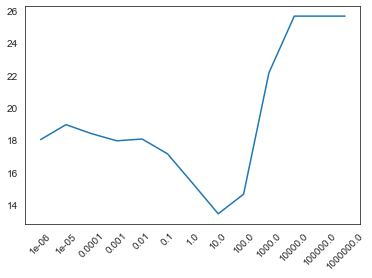

In [24]:
cv_estimator = joblib.load('mlp_alpha_search_results.joblib')

print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('best_alpha = %.2f' % (cv_estimator.best_params_['regressor__mlp__alpha']))
print('best_cv_mae = %.3f' % (-cv_estimator.best_score_))

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -cv_estimator.cv_results_['mean_test_score'])

## Testing the MLPR model

Do it over the entire dataset using `cross_val_predict`, get the CV MAE and draw the appropriate plots.

In [27]:
y_pred_mlp_cv = np.clip(cross_val_predict(cv_estimator.best_estimator_, x, y, cv=kf, n_jobs=-1), 0., 200.)

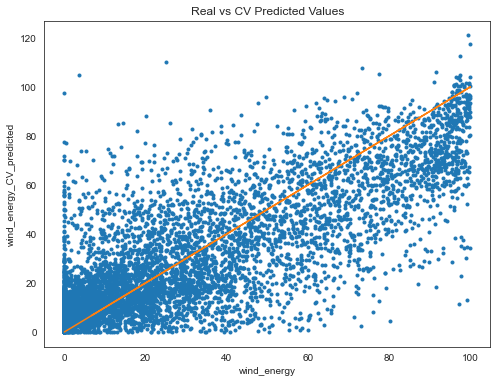

In [28]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot(y, y_pred_mlp_cv, '.', y, y, '-')

## MLP Residual histograms and relationship with targets

Show and discuss them.

mae: 15.682


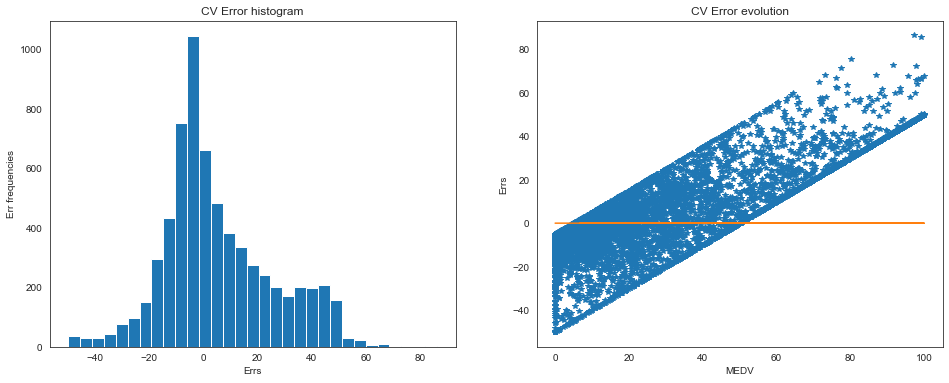

In [17]:
err = y - y_pred_mlp_cv

print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("wind_energy")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()

# SV Regressor

Repeat the previous steps with an SVR model with the same structure.

We will work with Gaussian kernels, so we have to set two hyperparameters, `C, gamma` plus the `epsilon` insensitivity. We have to explore **three** hyperparameters, so search times may increase considerably.  
To shorten fit times we downsample the original data to values every three hours. You can use for this Pandas methods such as `resample, asfreq` and `dropna`.

In [19]:
sample_df = df.resample('3H').first()
sample_df.head(10)

,U10,V10,U100,V100,v10,v100,target
TIMESTAMP,,,,,,,
2012-01-01 00:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400
2012-01-01 06:00:00,1.986038,0.796304,2.655406,0.882648,2.139730,2.798258,16.878113
2012-01-01 09:00:00,-1.380191,2.903624,-3.048145,6.041520,3.214959,6.766916,15.318109
2012-01-01 12:00:00,-2.340389,0.617855,-6.095209,1.564929,2.420571,6.292899,14.782445
2012-01-01 15:00:00,-2.020323,-0.455396,-5.185562,-1.845935,2.071012,5.504319,24.104877
2012-01-01 18:00:00,-0.234062,-3.575916,0.028920,-8.864540,3.583568,8.864587,25.345362
2012-01-01 21:00:00,0.431304,-3.920464,1.175177,-8.187682,3.944117,8.271588,73.545717
2012-01-02 00:00:00,1.468088,-5.200273,2.254640,-7.688174,5.403529,8.011955,76.045483


In [20]:
x = sample_df[l_vars].values
y = sample_df[['target']].values.reshape(-1,)
num_patterns, dim = x.shape
num_patterns, dim

(2193, 6)

In [21]:
l_C     = [10.**k for k in range(-3, 4)] 
l_gamma = list( np.array([2.**k for k in range(-2, 7)]) / dim)
l_epsilon = [2.**k for k in range(-6, 0)]

param_grid ={'regressor__svr__C': l_C,
             'regressor__svr__gamma': l_gamma,
             'regressor__svr__epsilon': l_epsilon}

print("num_hyperparams", len(l_C) * len(l_gamma) * len(l_epsilon))

mm_sc = MinMaxScaler()
svr = SVR(kernel='rbf', 
          shrinking=False, 
          tol=1.e-3)

regr = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                       ('svr', svr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error', 
                            refit=True,
                            n_jobs=-1,
                            return_train_score=True,
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x, y)
print("grid_search_time: %f segundos" % (time.time() - t_0))

f_pkl = open("c_gamma_epsilon_cv_search_energy_wind.pkz", 'wb') 
pickle.dump(cv_estimator, f_pkl)
f_pkl.close()

num_hyperparams 378
Fitting 3 folds for each of 378 candidates, totalling 1134 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   34.2s


grid_search_time: 514.999659 segundos


[Parallel(n_jobs=-1)]: Done 1134 out of 1134 | elapsed:  8.6min finished


In [22]:
f_pkl = open("c_gamma_epsilon_cv_search_energy_wind.pkz", 'rb') 
cv_estimator = pickle.load(f_pkl)
f_pkl.close()

In [23]:
print("C_range: %.4f - %.0f" % (np.array(l_C).min(), np.array(l_C).max()))
print("\tbest_C:", cv_estimator.best_params_['regressor__svr__C']) 

print("gamma_range: %.5f - %.5f" % (np.array(l_gamma).min(), np.array(l_gamma).max()))
print("\tbest_gamma:", cv_estimator.best_params_['regressor__svr__gamma'])

print("epsilon_range: %.5f - %.3f" % (np.array(l_epsilon).min(), np.array(l_epsilon).max()))
print("\tbest_epsilon:", cv_estimator.best_params_['regressor__svr__epsilon'])

C_range: 0.0010 - 1000
	best_C: 1.0
gamma_range: 0.04167 - 10.66667
	best_gamma: 5.333333333333333
epsilon_range: 0.01562 - 0.500
	best_epsilon: 0.125


In [24]:
df_C_gamma_epsilon_search = pd.DataFrame.from_dict(cv_estimator.cv_results_)
df_C_gamma_epsilon_search.sort_values(by='mean_test_score', ascending=False)[['param_regressor__svr__C',\
                                                                      'param_regressor__svr__gamma',\
                                                                      'param_regressor__svr__epsilon',\
                                                                      'mean_test_score']][ : 5]

,param_regressor__svr__C,param_regressor__svr__gamma,param_regressor__svr__epsilon,mean_test_score
196,1,5.33333,0.125,-12.976252
169,1,5.33333,0.015625,-13.003942
249,10,2.66667,0.125,-13.019025
187,1,5.33333,0.0625,-13.019426
178,1,5.33333,0.03125,-13.023488


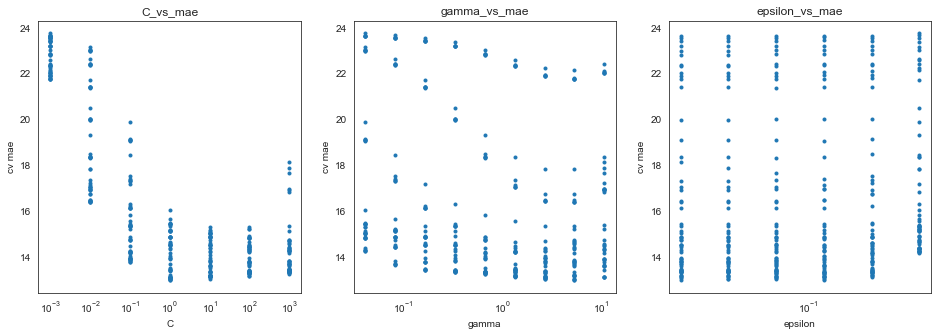

In [25]:
plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.title('C_vs_mae')
plt.xlabel('C')
plt.ylabel('cv mae')
plt.xscale('log')
#plt.ylim(1.8, 2.2)
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__C'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 2)
plt.title('gamma_vs_mae')
plt.xlabel('gamma')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__gamma'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.subplot(1, 3, 3)
plt.title('epsilon_vs_mae')
plt.xlabel('epsilon')
plt.ylabel('cv mae')
plt.xscale('log')
_ = plt.plot( df_C_gamma_epsilon_search['param_regressor__svr__epsilon'], -df_C_gamma_epsilon_search['mean_test_score'], '.')

plt.show()

In [26]:
best_estimator = cv_estimator.best_estimator_

scores = cross_val_score(best_estimator, x, y, scoring="neg_mean_absolute_error", cv=kf, n_jobs=2)

print("mae_mean: %.3f\t\tmae_std: %.3f" % (-scores.mean(), scores.std()))

mae_mean: 12.976		mae_std: 1.296


In [27]:
from sklearn.model_selection import cross_val_predict

y_pred_svr = np.clip( cross_val_predict(best_estimator, x, y, cv=kf, n_jobs=-1), 0., 200.)

print("mae: {0:.3f}".format(mean_absolute_error(y, y_pred_svr)))

mae: 15.285


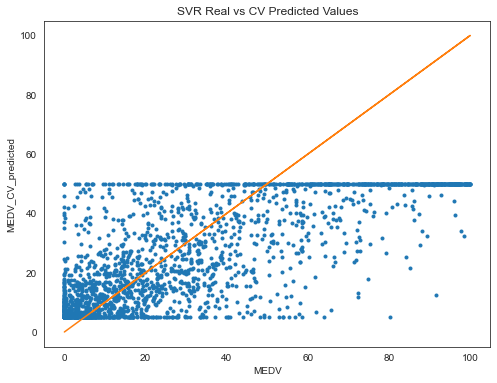

In [28]:
plt.figure( figsize=(8,6))

plt.title('SVR Real vs CV Predicted Values')
plt.xlabel('wind_energy')
plt.ylabel('wind_energy_CV_predicted')
_ = plt.plot(fy, y_pred_svr, '.', y, y, '-')

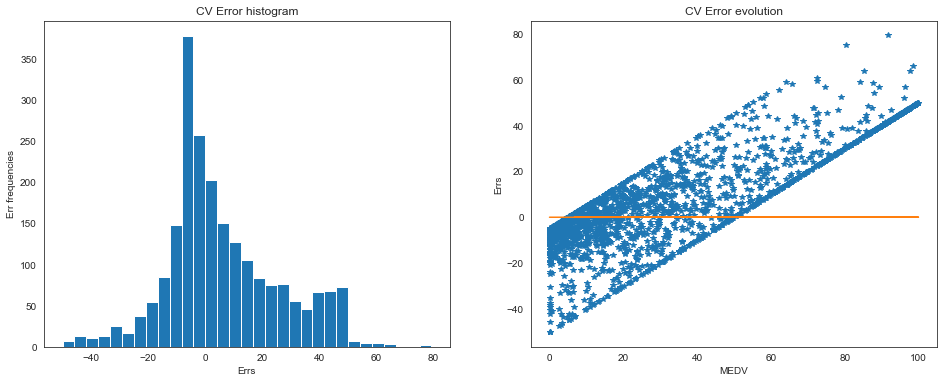

In [29]:
err = y - y_pred_svr

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y, err, '*', y, 0.*y, '-')

plt.show()

# MLPR and SVR comparison

Compare them and draw the appropriate conclusions.

# Trying to improve the estimator

Me may try to improve the MLPR and SVR results by enlarging the features set with the square and cube powers of the absolute velocities.

Redo the previous MLPR and SVR analysis and conclusions over the enlarged dataset with the same analysis structure.

In [30]:
square_abs_vel_10 = df[['v10']]**2
square_abs_vel_100 = df[['v100']]**2
cube_abs_vel_10 = df[['v10']]**2
cube_abs_vel_100 = df[['v100']]**3


In [31]:
df_large = df
df_large[['sqr_v10']] = square_abs_vel_10
df_large[['sqr_v100']] = square_abs_vel_100
df_large[['cub_v10']] = cube_abs_vel_10
df_large[['cub_v100']] = cube_abs_vel_10

In [32]:
df_large.head()

,U10,V10,U100,V100,v10,v100,target,sqr_v10,sqr_v100,cub_v10,cub_v100
TIMESTAMP,,,,,,,,,,,
2012-01-01 01:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000,11.706869,21.644209,11.706869,11.706869
2012-01-01 02:00:00,2.521695,-1.796960,3.344859,-2.464761,3.096451,4.154892,5.487912,9.588009,17.263129,9.588009,9.588009
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400,7.817238,13.783229,7.817238,7.817238
2012-01-01 04:00:00,2.457504,-0.143642,3.215233,-0.355546,2.461699,3.234831,16.511606,6.059961,10.464133,6.059961,6.059961
2012-01-01 05:00:00,2.245898,0.389576,2.957678,0.332701,2.279435,2.976332,15.694013,5.195826,8.858551,5.195826,5.195826


In [33]:
x_large = df_large[list(l_vars) + ['sqr_v10', 'sqr_v100', 'cub_v10', 'sqr_v100']]
y_large = df_large[['target']]

## MLPR

In [34]:
# select alpha in mlp regression by CV
n_folds = 3
kf = KFold(n_folds, shuffle=False)
hidden_layer_sizes = (30, 30)

mlpr =  MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, 
                     activation='relu', 
                     solver='lbfgs', 
                     early_stopping=True,
                     tol=1.e-3, 
                     max_iter=10000)

regr = Pipeline(steps=[('std_sc', StandardScaler()),
                       ('mlp', mlpr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

l_alpha = [10.**k for k in range(-6, 7)]
param_grid = {'regressor__mlp__alpha': l_alpha}  
#'regressor__mlp__hidden_layer_sizes': [(20,), (20, 20), (20, 20, 20)]}


cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error',
                            return_train_score=True,
                            refit=True,
                            n_jobs=-1, 
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x_large, y_large)
t_1 = time.time() 
print("\nmlp_grid_search_time: %.2f" % ((t_1 - t_0)/60.))
        
# saving alpha_search in a pickle    
f_name = 'mlp_large_alpha_search_results.joblib'
joblib.dump(cv_estimator, f_name, compress=3)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed: 11.4min finished



mlp_grid_search_time: 11.48


['mlp_large_alpha_search_results.joblib']

alpha_range: 0.00 - 1000000.00
best_alpha = 10.00
best_cv_mae = 13.438


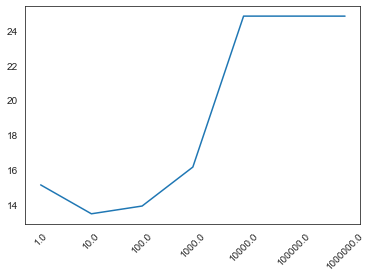

In [35]:
cv_estimator = joblib.load('mlp_large_alpha_search_results.joblib')

print("alpha_range: %.2f - %.2f" % (np.array(l_alpha).min(), np.array(l_alpha).max()))
print('best_alpha = %.2f' % (cv_estimator.best_params_['regressor__mlp__alpha']))
print('best_cv_mae = %.3f' % (-cv_estimator.best_score_))

plt.xticks(range(len(l_alpha)), l_alpha, rotation=45)
_ = plt.plot( -cv_estimator.cv_results_['mean_test_score'])

In [36]:
y_large_pred_mlp_cv = np.clip( cross_val_predict(cv_estimator.best_estimator_, x_large, y_large, cv=kf, n_jobs=-1), 5., 50.)

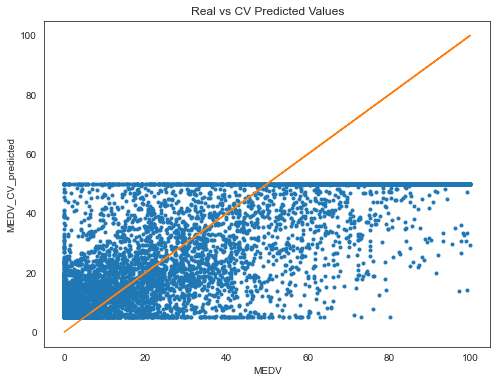

In [37]:
plt.figure( figsize=(8,6))

plt.title('Real vs CV Predicted Values')
plt.xlabel('MEDV')
plt.ylabel('MEDV_CV_predicted')
_ = plt.plot(y_large, y_large_pred_mlp_cv, '.', y_large, y_large, '-')

mae: 15.717


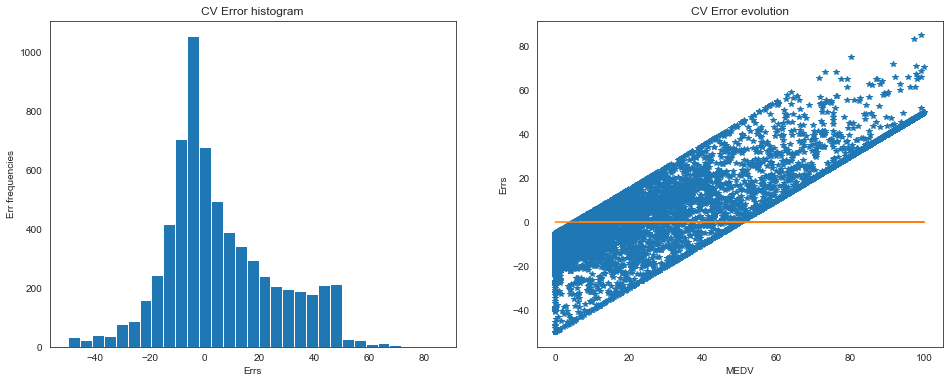

In [38]:
err = y_large - y_large_pred_mlp_cv

print("mae: %.3f" % (abs(err).mean()) )

plt.figure( figsize=(16,6))

plt.subplot(1,2,1)
plt.title("CV Error histogram")
plt.xlabel("Errs")
plt.ylabel("Err frequencies")
_ = plt.hist(err, bins=31)

plt.subplot(1,2,2)
plt.title("CV Error evolution")
plt.xlabel("MEDV")
plt.ylabel("Errs")
_ = plt.plot(y_large, err, '*', y_large, 0.*y_large, '-')

plt.show()

## SVR


In [39]:
df_large_sample = df_large.resample('3H').first()
df_large_sample.head(10)

,U10,V10,U100,V100,v10,v100,target,sqr_v10,sqr_v100,cub_v10,cub_v100
TIMESTAMP,,,,,,,,,,,
2012-01-01 00:00:00,2.124600,-2.681966,2.864280,-3.666076,3.421530,4.652334,0.000000,11.706869,21.644209,11.706869,11.706869
2012-01-01 03:00:00,2.672210,-0.822516,3.508448,-1.214093,2.795932,3.712577,11.023400,7.817238,13.783229,7.817238,7.817238
2012-01-01 06:00:00,1.986038,0.796304,2.655406,0.882648,2.139730,2.798258,16.878113,4.578446,7.830248,4.578446,4.578446
2012-01-01 09:00:00,-1.380191,2.903624,-3.048145,6.041520,3.214959,6.766916,15.318109,10.335960,45.791152,10.335960,10.335960
2012-01-01 12:00:00,-2.340389,0.617855,-6.095209,1.564929,2.420571,6.292899,14.782445,5.859165,39.600575,5.859165,5.859165
2012-01-01 15:00:00,-2.020323,-0.455396,-5.185562,-1.845935,2.071012,5.504319,24.104877,4.289090,30.297526,4.289090,4.289090
2012-01-01 18:00:00,-0.234062,-3.575916,0.028920,-8.864540,3.583568,8.864587,25.345362,12.841963,78.580900,12.841963,12.841963
2012-01-01 21:00:00,0.431304,-3.920464,1.175177,-8.187682,3.944117,8.271588,73.545717,15.556062,68.419174,15.556062,15.556062
2012-01-02 00:00:00,1.468088,-5.200273,2.254640,-7.688174,5.403529,8.011955,76.045483,29.198127,64.191418,29.198127,29.198127


In [40]:
l_vars_lg = list(l_vars) + ['sqr_v10', 'sqr_v100', 'cub_v10', 'sqr_v100']
x_large_sample = df_large_sample[l_vars_lg].values
y_large_sample = df_large_sample[['target']].values.reshape(-1,)
num_patterns, dim = x_large_sample.shape
num_patterns, dim

(2193, 10)

In [41]:
l_C     = [10.**k for k in range(-3, 4)] 
l_gamma = list( np.array([2.**k for k in range(-2, 7)]) / dim)
l_epsilon = [2.**k for k in range(-6, 0)]

param_grid ={'regressor__svr__C': l_C,
             'regressor__svr__gamma': l_gamma,
             'regressor__svr__epsilon': l_epsilon}

print("num_hyperparams", len(l_C) * len(l_gamma) * len(l_epsilon))

mm_sc = MinMaxScaler()
svr = SVR(kernel='rbf', 
          shrinking=False, 
          tol=1.e-3)

regr = Pipeline(steps=[('minmax_sc', MinMaxScaler()),
                       ('svr', svr)])

y_transformer = StandardScaler()
inner_estimator = TransformedTargetRegressor(regressor=regr,
                                             transformer=y_transformer)

cv_estimator = GridSearchCV(inner_estimator, 
                            param_grid=param_grid, 
                            cv=kf, 
                            scoring='neg_mean_absolute_error', 
                            refit=True,
                            n_jobs=-1,
                            return_train_score=True,
                            verbose=1)

t_0 = time.time()
cv_estimator.fit(x_large_sample, y_large_sample)
print("grid_search_time: %f segundos" % (time.time() - t_0))

f_pkl = open("c_gamma_epsilon_cv_search_energy_wind.pkz", 'wb') 
pickle.dump(cv_estimator, f_pkl)
f_pkl.close()

num_hyperparams 378
Fitting 3 folds for each of 378 candidates, totalling 1134 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 1134 out of 1134 | elapsed:  7.5min finished


grid_search_time: 449.235213 segundos


In [ ]:
y_pred_mlpr = np.clip( cross_val_predict(cv_estimator_mlp.best_estimator_, x, y, cv=kf, n_jobs=-1), 5., 50.)

print("mlpr_mae: {0:.3f}".format(mean_absolute_error(y, y_pred_mlpr)))
print("svr_mae: {0:.3f}".format(mean_absolute_error(y, y_pred_svr)))

# Final conclusions